In [2]:
import full_model
import fast_model
import fast_model_improved
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from joblib import Parallel, delayed
import pickle

## Load the model

In [3]:
# Load the graph from the file
save_path = '/Users/huberyhu/Desktop/SURP/im_deinfluence/network_data/ca-GrQc.gpickle'
try:
    with open(save_path, 'rb') as f:
        G_fb = pickle.load(f)
    print(f"Graph loaded from {save_path}")
except Exception as e:
    print(f"An error occurred while loading the graph: {e}")

# Display basic information about the graph
print(f"Number of nodes: {G_fb.number_of_nodes()}")
print(f"Number of edges: {G_fb.number_of_edges()}")
print(f"Average degree: {sum(dict(G_fb.degree()).values()) / G_fb.number_of_nodes():.2f}")

# Perform additional operations on the graph
# Example: Print the neighbors of node 0
if 0 in G_fb:
    print(f"Neighbors of node 0: {list(G_fb.neighbors(0))}")
else:
    print("Node 0 is not in the graph")

Graph loaded from /Users/huberyhu/Desktop/SURP/im_deinfluence/network_data/ca-GrQc.gpickle
Number of nodes: 5242
Number of edges: 28980
Average degree: 11.06
Node 0 is not in the graph


In [11]:
# def generate_and_find_inf(steps, num_influencers=0):

#     model_inf = fast_model_improved.InfluenceDeinfluenceModel(G_fb)
#     model_inf.set_initial_states()
#     initial_influencers = model_inf.greedy_hill_climbing(num_influencers, steps)

#     #initial_influencers = model_inf.greedy_hill_climbing_new(num_influencers)
#     print("Optimized Initial Influencers:", initial_influencers)

#     return model_inf, initial_influencers

In [4]:
def generate_and_find_inf(steps, num_influencers=10):

    model = fast_model_improved.InfluenceDeinfluenceModel(G_fb)
    model.selected_influencers = model.random_influencers(num_influencers)

    #initial_influencers = model_inf.greedy_hill_climbing_new(num_influencers)
    print("Initial Influencers:", model.selected_influencers)

    return model, model.selected_influencers

In [5]:
inf_steps = 2
num_influencers = 50

results = generate_and_find_inf(inf_steps, num_influencers=num_influencers)

(model, optimized_influencers) = results

Initial Influencers: {10497, 16643, 20620, 3599, 7311, 24463, 8211, 8727, 19351, 15899, 17180, 5661, 7069, 14369, 17187, 20260, 12709, 21798, 10925, 24240, 14132, 26038, 11964, 17341, 573, 18246, 4298, 2123, 21324, 23167, 18000, 16083, 2774, 15961, 5209, 19548, 19677, 15583, 19557, 2409, 6635, 3441, 12786, 2420, 21754, 11899, 3068, 22269, 254, 9471}


In [6]:
# Function to run the cascade and count deinfluenced nodes
def count_deinfluenced(model, inf, deinf, num_runs, steps):
    total_deinfluenced = 0
    for run in range(num_runs):
        model.reset_graph()
        model.set_influencers(inf)
        model.set_deinfluencers(deinf)
        model.run_cascade(steps)
        deinfluenced_count = model.evaluate_deinfluence()
        total_deinfluenced += deinfluenced_count
        model.reset_graph()
        
    average_deinfluenced = total_deinfluenced / num_runs

    return average_deinfluenced

def count_influenced(model, inf, deinf, num_runs, steps):
    total_influenced = 0
    for run in range(num_runs):
        model.reset_graph()
        model.set_influencers(inf)
        model.set_deinfluencers(deinf)
        model.run_cascade(steps)
        influenced_count = model.evaluate_influence()
        total_influenced += influenced_count
        model.reset_graph()
        
    average_influenced = total_influenced / num_runs
    #print(f"Average deinfluenced nodes: {average_deinfluenced}")

    return average_influenced


# Function to run the cascade and count deinfluenced nodes
def count_transistion(model, inf, deinf, num_runs, steps):
    model = full_model.InfluenceDeinfluenceModel(model.graph)
    ist = 0
    dst = 0
    dit = 0

    for run in range(num_runs):
        model.transition_counts = {'I->S': 0, 'D->S': 0, 'D->I': 0}
        model.reset_graph()
        model.set_influencers(inf)
        model.set_deinfluencers(deinf)
        model.run_cascade(steps)
        transistions = model.transition_counts

        ist += transistions['I->S']
        dst += transistions['D->S']
        dit += transistions['D->I']

        #print(transistions['I->S'], transistions['D->S'], transistions['D->I'])

        transitions_array_cum = np.array([ist, dst, dit])
        #print(transitions_array_cum)

        model.reset_graph()
        model.transition_counts = {'I->S': 0, 'D->S': 0, 'D->I': 0}
        #print("------")
        
    averaged_transistions = transitions_array_cum / num_runs
    #print(f"Average deinfluenced nodes: {averaged_transistions}")

    return averaged_transistions

Degree Centrality Ranking: [21012, 21281, 22691, 12365, 6610, 9785, 21508, 17655, 2741, 19423, 15003, 14807, 15244, 12781, 1653, 7956, 25346, 773, 4164, 23293]
Closeness Centrality Ranking: [13801, 14485, 9572, 17655, 2654, 21012, 12545, 25006, 12365, 22691, 20478, 2741, 7689, 13276, 5052, 18866, 23293, 6610, 13096, 13929]
Betweenness Centrality Ranking: [13801, 9572, 14599, 7689, 13929, 5052, 14485, 2710, 14265, 17655, 10762, 2654, 19865, 13096, 1488, 14746, 23038, 13142, 16148, 7007]
Eigenvector Centrality Ranking: [21012, 2741, 12365, 21508, 9785, 15003, 25346, 7956, 14807, 12781, 773, 17655, 21281, 19423, 22691, 6610, 24955, 3372, 1653, 4164]
PageRank Centrality Ranking: [14265, 13801, 13929, 9572, 2710, 21281, 7689, 22691, 6264, 21012, 12365, 449, 4952, 9017, 9124, 5052, 10762, 7307, 1488, 19865]
Random Deinfluencers: [22778, 882, 12338, 11893, 15799, 2512, 23346, 17089, 8742, 23146, 20014, 4298, 5656, 22696, 17135, 896, 9095, 2001, 18218, 10433]
Deinfluencers from Influencers: [2

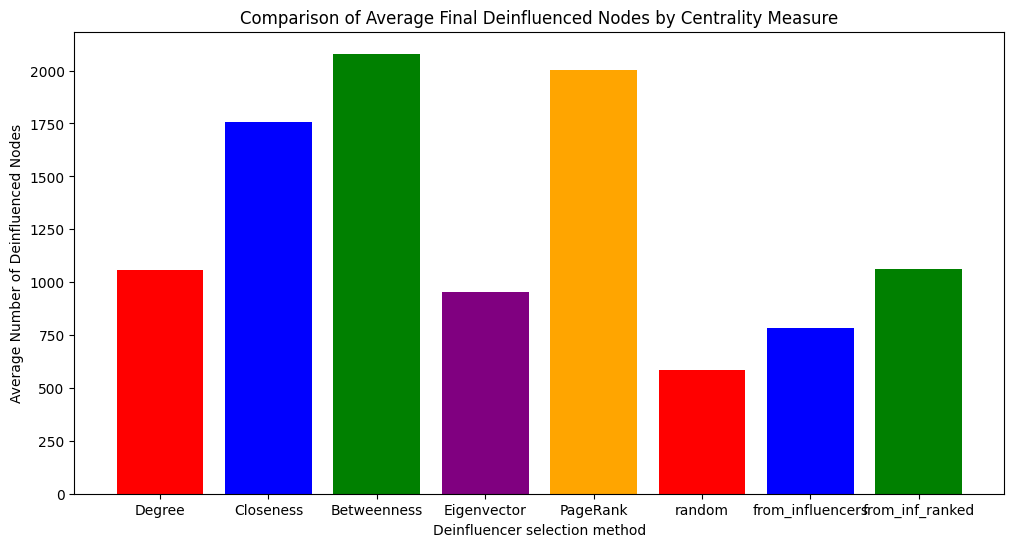

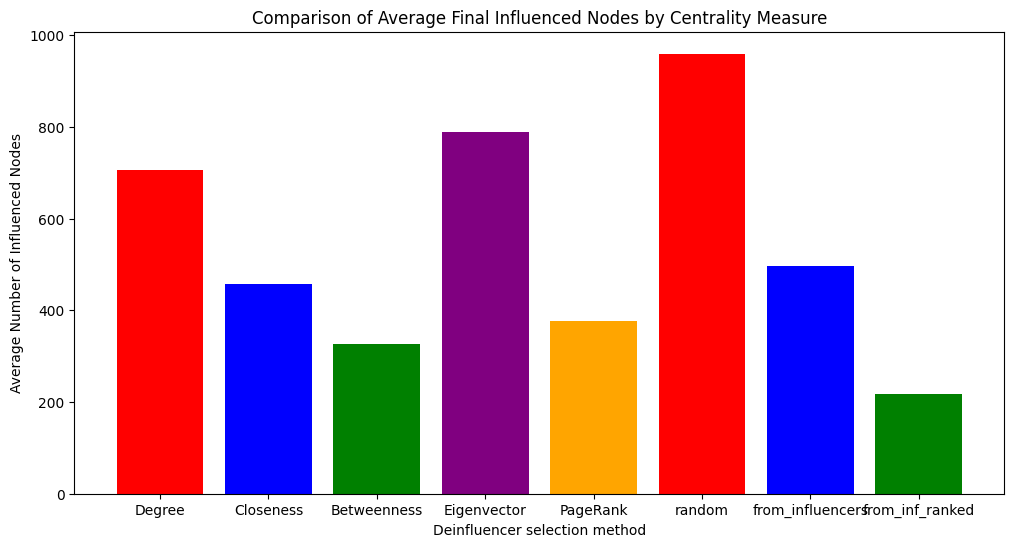

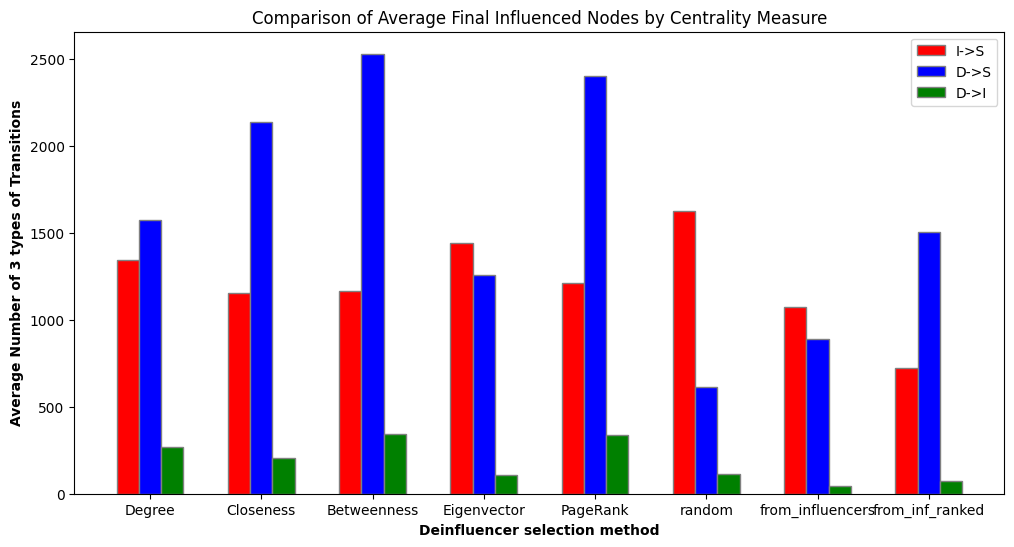

In [7]:
# Initialize the model
model.reset_graph()

# Rank nodes using different centrality measures
k_deinfluencers = 20

# Run cascades and count deinfluenced nodes for each centrality measure
num_runs = 3  # Number of times to run the cascade for averaging
steps = 3  # Number of steps to run the cascade

degree_centrality_ranking = model.select_deinfluencers_degree_centrality(k_deinfluencers)
closeness_centrality_ranking = model.select_deinfluencers_closeness_centrality(k_deinfluencers)
betweenness_centrality_ranking = model.select_deinfluencers_betweenness_centrality(k_deinfluencers)
eigenvector_centrality_ranking = model.select_deinfluencers_eigenvector_centrality(k_deinfluencers, max_iter=1000, tol=1e-06)
pagerank_centrality_ranking = model.select_deinfluencers_pagerank_centrality(k_deinfluencers)
random_deinfluencers = model.select_deinfluencers_random(k_deinfluencers)
#optimized_deinfluencers = model.greedy_hill_climbing_deinf(k_deinfluencers, 5, 10)
deinfleucers_from_influencers = model.select_deinfluencers_from_influencers(j=k_deinfluencers)
ranked_deinfleucers_from_influencers = model.select_deinfluencers_from_influencers_degree_centrality(k_deinfluencers)


print("Degree Centrality Ranking:", degree_centrality_ranking)
print("Closeness Centrality Ranking:", closeness_centrality_ranking)
print("Betweenness Centrality Ranking:", betweenness_centrality_ranking)
print("Eigenvector Centrality Ranking:", eigenvector_centrality_ranking)
print("PageRank Centrality Ranking:", pagerank_centrality_ranking)
print("Random Deinfluencers:", random_deinfluencers)
#print("Optimized Deinfluencers:", optimized_deinfluencers)
print("Deinfluencers from Influencers:", deinfleucers_from_influencers)
print("Ranked Deinfluencers from Influencers:", ranked_deinfleucers_from_influencers)


results_d = {
    'Degree': count_deinfluenced(model, optimized_influencers, degree_centrality_ranking, num_runs, steps),
    'Closeness': count_deinfluenced(model, optimized_influencers, closeness_centrality_ranking, num_runs, steps),
    'Betweenness': count_deinfluenced(model, optimized_influencers, betweenness_centrality_ranking, num_runs, steps),
    'Eigenvector': count_deinfluenced(model, optimized_influencers, eigenvector_centrality_ranking, num_runs, steps),
    'PageRank': count_deinfluenced(model, optimized_influencers, pagerank_centrality_ranking, num_runs, steps),
    'random': count_deinfluenced(model, optimized_influencers, random_deinfluencers, num_runs, steps),
    #'hill_climbing': count_deinfluenced(model, optimized_influencers, optimized_deinfluencers, num_runs, steps),
    'from_influencers': count_deinfluenced(model, optimized_influencers, deinfleucers_from_influencers, num_runs, steps),
    'from_inf_ranked': count_deinfluenced(model, optimized_influencers, ranked_deinfleucers_from_influencers, num_runs, steps)
}

results_i = { 
    'Degree': count_influenced(model, optimized_influencers, degree_centrality_ranking, num_runs, steps),
    'Closeness': count_influenced(model, optimized_influencers, closeness_centrality_ranking, num_runs, steps),
    'Betweenness': count_influenced(model, optimized_influencers, betweenness_centrality_ranking, num_runs, steps),
    'Eigenvector': count_influenced(model, optimized_influencers, eigenvector_centrality_ranking, num_runs, steps),
    'PageRank': count_influenced(model, optimized_influencers, pagerank_centrality_ranking, num_runs, steps),
    'random': count_influenced(model, optimized_influencers, random_deinfluencers, num_runs, steps),
    #'hill_climbing': count_influenced(model, optimized_influencers, optimized_deinfluencers, num_runs, steps),
    'from_influencers': count_influenced(model, optimized_influencers, deinfleucers_from_influencers, num_runs, steps),
    'from_inf_ranked': count_influenced(model, optimized_influencers, ranked_deinfleucers_from_influencers, num_runs, steps)
}

results_w = {
    'Degree': count_transistion(model, optimized_influencers, degree_centrality_ranking, num_runs, steps),
    'Closeness': count_transistion(model, optimized_influencers, closeness_centrality_ranking, num_runs, steps),
    'Betweenness': count_transistion(model, optimized_influencers, betweenness_centrality_ranking, num_runs, steps),
    'Eigenvector': count_transistion(model, optimized_influencers, eigenvector_centrality_ranking, num_runs, steps),
    'PageRank': count_transistion(model, optimized_influencers, pagerank_centrality_ranking, num_runs, steps),
    'random': count_transistion(model, optimized_influencers, random_deinfluencers, num_runs, steps),
    #'hill_climbing': count_transistion(model, optimized_influencers, optimized_deinfluencers, num_runs, steps),
    'from_influencers': count_transistion(model, optimized_influencers, deinfleucers_from_influencers, num_runs, steps),
    'from_inf_ranked': count_transistion(model, optimized_influencers, ranked_deinfleucers_from_influencers, num_runs, steps)
}



# Print the results
#for centrality, count in results.items():
    #print(f"{centrality}: {count:.2f} nodes deinfluenced on average")

# Plot the results
plt.figure(figsize=(12, 6))  # Increase the figure size
plt.bar(results_d.keys(), results_d.values(), color=['red', 'blue', 'green', 'purple', 'orange'])
plt.xlabel('Deinfluencer selection method')
plt.ylabel('Average Number of Deinfluenced Nodes')
plt.title('Comparison of Average Final Deinfluenced Nodes by Centrality Measure')
plt.show()


plt.figure(figsize=(12, 6))  # Increase the figure size
plt.bar(results_i.keys(), results_i.values(), color=['red', 'blue', 'green', 'purple', 'orange'])
plt.xlabel('Deinfluencer selection method')
plt.ylabel('Average Number of Influenced Nodes')
plt.title('Comparison of Average Final Influenced Nodes by Centrality Measure')
plt.show()

# Unpack the values
values1 = [val[0] for val in results_w.values()]
values2 = [val[1] for val in results_w.values()]
values3 = [val[2] for val in results_w.values()]

# Create a new figure
plt.figure(figsize=(12, 6))  # Increase the figure size

# Define the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(values1))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bars
plt.bar(r1, values1, color='red', width=bar_width, edgecolor='grey', label='I->S')
plt.bar(r2, values2, color='blue', width=bar_width, edgecolor='grey', label='D->S')
plt.bar(r3, values3, color='green', width=bar_width, edgecolor='grey', label='D->I')

# Add labels
plt.xlabel('Deinfluencer selection method', fontweight='bold')
plt.ylabel('Average Number of 3 types of Transitions', fontweight='bold')
plt.title('Comparison of Average Final Influenced Nodes by Centrality Measure')

# Add the xticks
plt.xticks([r + bar_width for r in range(len(values1))], results_w.keys())

# Create legend
plt.legend()

# Show the plot
plt.show()